# End-to-end Multi-Class Dog Breed Classfication


This notebook builds an end-to-wnd multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.


##1.  Problem

Identifying the breed of a dog, given the image of the dog

##2.  Data

The data was gotten from:
https://www.kaggle.com/c/dog-breed-identification

##3.  Evaluation

look at the kaggle competition to get the evaluation metrics

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


##4.  Features

Some information about the data:
* we are dealing with images(unstructured data) so its probably best we use deep learning/ transfer learning

* there are 120 breeds of dogs
( this means there are 120 different classes)

* there are around 10000+ images in the training set( these images have labels)

* there are around 10000+ images in the test set( these images have no labels, because we have to predict them)


In [ ]:
# !unzip "/content/drive/MyDrive/dog-breed-identification.zip" -d "drive/My Drive/Dog_Vision/"

### Get our workspace ready

* Import TensorFlow 2.x---- its the tool to create our pipeline
* Import TensorFlow Hub---- this is where we pick our model
* Make sure we are using a GPU
GPU is important cos we need more vast numerical computing power as we are running a vast data.. almost a  gigabyte worth of data

In [ ]:
# Import Tensorflow into Colab
import tensorflow as tf
print("Tf version:", tf.__version__)

In [ ]:
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)

In [ ]:
#check for GPU availability
print("GPU", "available (YESSSS!!!!" if tf.config.list_physical_devices("GPU") else "not available :(")

To get gpu running, go to runtime, change runtime type and select GPU, then save

## Getting data ready
this means turn data into tensors(pi array, matrix, numerical format )
Turning images into Tensors(numerical representation)

lets start by assessing our data and checking out the labels.



In [ ]:
#checkout the labels of our data
import pandas as pd
labels_csv=pd.read_csv("drive/MyDrive/dog-breed-identification/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())


In [ ]:
labels_csv.head()

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv["breed"].value_counts().median()

In [ ]:
# minimum number of images per class is 10, the ml model will do better at predicting than those with few images

In [ ]:
# Lets view an image
from IPython.display import Image
Image("drive/MyDrive/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg") # remember to put the image extension

## Getting images and their labels

lets get a list of all our image file pathnames



In [ ]:
labels_csv.head()

In [ ]:
# create pathnames from Image IDs

filenames=["drive/MyDrive/dog-breed-identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]

In [ ]:
# check the first 10 
filenames[:10]

In [ ]:
# Check whether number of filenames match number of actual image files
import os
os.listdir("drive/MyDrive/dog-breed-identification/train/")
# if len(os.listdir("drive/MyDrive/dog-breed-identification/train/"))==len(filenames):
  # print("Filenames match actual amount of files!!! Proceed.")
# else:
  # print("filenames do not match actual amount of files, check the target directory.")  

In [ ]:
# Check whether number of filenames match number of actual image files
import os
# os.listdir("drive/MyDrive/dog-breed-identification/train/")
if len(os.listdir("drive/MyDrive/dog-breed-identification/train/"))==len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("filenames do not match actual amount of files, check the target directory.")  

In [ ]:
# One more check
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

### Since we've now got our training image filepaths in a list, lets prepare our labels

In [ ]:
import numpy as np
labels=labels_csv["breed"].to_numpy()
# labels=np.array(labels) # does same thing as line 2
labels

In [ ]:
len(labels)

In [ ]:
#see if number of labels matches the number of filenames
if len(labels)==len(filenames):
    print("Number of labels matches number of filenames!")
else:
    print("Number of labels does not match number of filenames, check data directories!")
    

In [ ]:
# ml models cant take strings
# find the unique label values cos they are repeated
unique_breeds=np.unique(labels)
unique_breeds


In [ ]:
len(unique_breeds)
# this corresponds to the data on kaggle

In [ ]:
# Turn a single label into an array if an array of booleans
print(labels[0])
labels[0]==unique_breeds

In [ ]:
# Turn every label into a boolean array
boolean_labels=[label==unique_breeds for label in labels]
boolean_labels[:2]

In [ ]:
len(boolean_labels)

In [ ]:
len(labels)

In [ ]:
# Example : Turning array into integers
print(labels[0]) # original label
print(np.where(unique_breeds==labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be 1 where the sample label occurs

In [ ]:
print(labels[2])
print(boolean_labels[2].astype(int))

In [ ]:
boolean_labels

In [ ]:
filenames[:10]

# creating our own validation set
since the  dataset from Kaggle does not provide a validation set, we will create our own

In [ ]:
# Setup X and y variables
X=filenames
y=boolean_labels

In [ ]:
len(filenames)

### We are going to start off experimenting with 1000 images and increase as needed

In [ ]:
# set number of images to use for experimenting
NUM_IMAGES=1000 #@param {type:"slider",min:1000, max:10000, step:1000}

In [ ]:
# lets split our data into train and validation sets
from sklearn.model_selection import train_test_split

# split them into training and validation of total size NUM_IMAGES
X_train, X_val,y_train,y_val=train_test_split(X[:NUM_IMAGES],
                                              y[:NUM_IMAGES],
                                             test_size=0.2,
                                             random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

In [ ]:
#lets have a geez at the training data
X_train[:5],y_train[:2]

## Preprocessing images(turning images into Tensors)

1. To preprocess our images into Tensors, we write a function that does a few things

2. Use Tensorflow to read the file and save it to a variable "image"

3. Turn "image" (a jpg) into Tensors

4. Resize the "image" to be a shape of (224,224)

5. Return the modified "image"

## Before we do, lets see what importing an image looks like

In [ ]:
#converting images into numpy array
from matplotlib.pyplot import imread
image=imread(filenames[42])
image.shape #h, w,color channel(r,g,b pixels(0-255))

In [ ]:
image

In [ ]:
# converting numpy image into tensor
tf.constant(image)[:2] # note that the nos are same as numpy, but its gonna run a lot faster in a gpu than a normal numpy image

## Now we have seen what an image looks like as a  Tensor, lets make a function to preprocess them
1. Take an image filepath as input

2. Use Tensorflow to read the file and save it to a variable "image"

3. Turn "image" (a jpg) into Tensors

4. Normalize our image (convert color channel values form 0-255 to 0-1

5. Resize the "image" to be a shape of (224,224)

6. Return the modified "image"


In [ ]:
# Define image size
IMG_SIZE=224

# Create a function for preprocessing image
def process_image(image_path, img_size=IMG_SIZE):
    """
    Takes an image file path and an image size and turns the image into a Tensor.
    """
    #Read in an image file
    image=tf.io.read_file(image_path) # takes content and turn into a long tensor codes
    
    # Turn the jpeg image into numerical Tensor with 3 colour channels(R,G,B)
    image=tf.image.decode_jpeg(image,channels=3)
    
    #convert the color channel values from 0-255 to 0-1 values(normalization)
    image=tf.image.convert_image_dtype(image, tf.float32) # it makes computing easy
    
    #resize the image to our desired value(224,224)
    image=tf.image.resize(image,size=[IMG_SIZE, IMG_SIZE])

    return image

In [ ]:
tensor=tf.io.read_file(filenames[26])
tensor

## Turning data into batches

Why turn our data into batches?

lets say you are tyring to process 10000+ images in one go... they all might not fit into memory

So thats y we do about 32(this is the batch size) images at a time(you can manually adjust the batch size if need be)

In order to use tensorflow effectively, we need our data in the form of Tensor tuples which look like this: (image, label)

In [ ]:
# Create a simple function to return a tuple (image,label)

def get_image_label(image_path,label):
    """
    Takes an image file path name and the associated label, 
    processes the image and returns a tuple of (image,label)
    """
    image=process_image(image_path)
    return image, label

In [ ]:
# Demo of above
(process_image(X[42]),tf.constant(y[42]))

### Now we've got a way to turn data into tuples of Tensors in the form `(image, label)`... lets make a function to turn all of our data (`x`& `y`) into batches!



In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE=32

#Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs
    Shuffles the data if it's training data but doesnt shuffle if it's validation data
    Also accepts test data as input(no labels).
    """
    # if the data is a test dataset, we probably dont have labels
    if test_data:
        print("Creating test data batches....")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X))) # creates a dataset out of a tensor.. only filepaths(no labels)
        data_batch=data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    # if the data is valid dataset, we dont need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                                 tf.constant(y))) #labels
        data_batch=data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
                                                
    #if test_data is false as well as valid_data is false,then it becomes a training data
    else:
        print("Creating training data batches....")
        # Turn filepaths and labels into Tensors
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                tf.constant(y)))
        # shuffling pathnames and labels before mapping... image processor function is faster than shuffling
        data=data.shuffle(buffer_size=len(X))
         #it takes a longer time to shuffle images thanit does to shuffle filename , thats y we shuffle before mapping                                       
        
        # creates (image, label) tuples (this also turns the image path into a preprocessed image)                                       
        data=data.map(get_image_label)
                                                
        # Turn training data into batches
        data_batch=data.batch(BATCH_SIZE)
    return data_batch

In [ ]:
# Create training and validation data batches 
train_data=create_data_batches(X_train,y_train)
val_data=create_data_batches(X_val,y_val, valid_data=True)

In [ ]:
# check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

In [ ]:
y[0]

## Visualizing Data Batches

Our data is now in batches, however these can be a little hard to understand/comprehend, lets visualize them

In [ ]:
import matplotlib.pyplot as plt

#create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """

  # Setup the figure
  plt.figure(figsize=(10,10))

  #Loop throiugh 25(for displaying 25 images)
  for i in range(25):
    # create subplots(5 rows, 5 columns)
    ax=plt.subplot(5,5,i+1) # rows, columns, index
    #Display an image
    plt.imshow(images[i])
    #Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    #Turn the gridlines off
    plt.axis("off")


In [ ]:
train_data

In [ ]:
train_images, train_labels=next(train_data.as_numpy_iterator())

In [ ]:
show_25_images(train_images, train_labels)

## Building a model

Before we build a model, there are a few things we need to define:
 * the input shape(our images shape in the form of tensors) to our model
 * the output shape(image labels, in the form of tensors)of our model
 * the URL of the model we want to use from TensorFlow Hub( we will use transfer learning instead of building a model from scratch)
 https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
 
 TensorFlow, Pytorch, model zoo, paperswithcode, are deep learning frameworks
 
 TensorFlowHub is a lib for publication, discovery and consumption of reusable parts of ml models. 
 
 Transfer learning can
  * train a model with smaller dataset
  * imrove generalization
  * speed up training
  
  tf.keras is Tensorflow high level API for building and training deep learning models
  useful for fast prototyping, state-of-the-art research and production
  it is user friendly, modular and composable, easy to extend

In [ ]:
IMG_SIZE

In [ ]:
# Setup input shape to the model
INPUT_SHAPE=[None, IMG_SIZE, IMG_SIZE, 3 ] # batch, height, width, color channels

#Setup output shape of our model
OUTPUT_SHAPE=len(unique_breeds)

#setup model URL from Tensorflow Hub
MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

### Now we've got inputs, outputs and model ready to go. Lets put them together into a Keras deep learning model!

Knowing this. lets create a function which:
    
    * Takes the input shape, output shape and the model we've chosen as parameters
    
    * defines the layers in  a keras model in sequential fashion (do this first, then this, then that)
    
    * compiles the model(says how it should be evaluated and improved)
     
     * builds the model(tells the model the input shape it will be getting)
     
     * returns the model
        
All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [ ]:
# create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Buildig model with ", MODEL_URL)
    
     # Setup the model layers
    model=tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # layer 1 (input layer)
      tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                            activation="softmax") # layer 2 (output layer)
    ])
    
    # compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])
  
    # Build the model
    model.build(INPUT_SHAPE)
    
    return model

In [ ]:
model=create_model()
model.summary()

## Creating Callbacks

callbacks are helper functions our model can use during training to do things like:
 * save the progress
 * check its progress
 * stop training early if a model stops improving....


We will create two callbacks

1. one for TensorBoard which helps track our models progress 

2, and an early stopping callback which prevents our model from training too long


## TensorBoard CallBack

To setup a TensorBoaord callback, we need to do 3 things

1. Load the TensorBoard notebook extension

2. Create a TensorBoard callback which is able to save logs to a directory and pass it our models 'fit()' function

3. Visaulize our models training logs with the '%tensorboard magic function (we will do this after model training)

In [ ]:
# Load TensorBoard notebook extension
# %load_ext tensorboard
%reload_ext tensorboard


In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs 
    logdir=os.path.join("drive/MyDrive/dog-breed-identification/logs", # to have access to the path of the log file
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

### EARLY STOPPING CALLBACK

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving


https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


In [ ]:
#create early stopping callback
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", # monitor by defaults checks for val-loss
                                                patience=3) # no of epochs with no improvement after training has been stopped

## Training a model (on subset of data)

our first model is only going to train on 1000 images to make sure everything is working... to prevent a break in codes

Number of epochs is how many passes we want our model to do

pass is our model finding patterns in our images and finding out which label belongs to which image


In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# check to make sure we are still running on a gpu

print("GPU", "available (YESSSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

In [ ]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version
    """
    # create a model
    model=create_model()
    
    # create new TensorBoard session evrytime we train a model
    tensorboard=create_tensorboard_callback()
     
    # fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
              epochs = NUM_EPOCHS, # chances our model has to pass over the training data to find patterns
              validation_data=val_data,
              validation_freq=1, # how often we want to test the patterns the model has found on the valudation data 
              callbacks=[tensorboard, early_stopping])
            
     # Return the fitted model
    return model


In [ ]:
# Fit the model to the data
model=train_model()

# for the first time note that the first epoch will take the longest time cos we initialize at first, load data into the gpu

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its content

In [ ]:
%tensorboard --logdir drive/MyDrive/dog-breed-identification/logs/

## Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data(not used to train on)
predictions = model.predict(val_data, verbose=1) #verbose means show me ur progress as u predict
predictions

In [ ]:
# First prediction
index=0
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"sum:{np.sum(predictions[index])}")
print(f"Max index:{np.argmax(predictions[index])}")
print(f"predicted labels: {unique_breeds[np.argmax(predictions[index])]}")


**Note** prediction prob is also called confidence level

### Having the above functionality is great but we want to be able to do it at scale

#### and it would be even better if we could see the image the prediction is being made on!

**TIDBIT** one of the important steps expected of a data scientist or ml is being able to **evaluate** a model  

In [ ]:
# turn probs into their respective labels (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

# get a predicted label based on an array of prediction probabilities
pred_label=get_pred_label(predictions[81])
pred_label

In [ ]:
val_data

Now since our validation data is still i a batch dataset, we will have to unbatchify it to make predictions to the validation labels(truth labels)

In [ ]:
# create a function to unbatch a batch dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays
    of images and labels.
    """
    images =[]
    labels =[]

# loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
      images.append(image)
      labels.append(unique_breeds[np.argmax(label)])
    return images,labels


#unbatchify the validation data
val_images, val_labels=unbatchify(val_data)
val_images[0], val_labels[0]

In [ ]:
get_pred_label(labels[0])

In [ ]:
get_pred_label(predictions[0])


In [ ]:
get_pred_label(val_labels)

Now we've got ways to get:
 * Prediction labels
 * Validation labels(truth labels)
 * Validation images

Lets make some function to make these all a bit more visualze

We will create a function which:
 * Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer
  * Convert the prediction probabs to a  predicted label
  * Plot the predicted label, its predicted probability, the truth label and the target image on a single plot

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    view the prediction, ground truth and image for sample n
    """
    pred_prob, true_label, image=prediction_probabilities[n], labels[n], images[n]

    # get the pred label
    pred_label=get_pred_label(pred_prob)

    # plot image and remove ticks
    plt.imshow(image) 
    plt.xticks([])
    plt.yticks([])

    #change the color of the title depending on if the prediction is right or wrong

    if pred_label==true_label:
        color="green"
    else:
        color="red"

    #change plot title to be predicted, probability of prediction and truth label
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)
            
plot_pred(prediction_probabilities=predictions,
              labels=val_labels,
              images=val_images
              )

In [ ]:
plot_pred(prediction_probabilities=predictions,
              labels=val_labels,
              images=val_images,
              n=42)

In [ ]:
plot_pred(prediction_probabilities=predictions,
              labels=val_labels,
              images=val_images,
              n=77)

Now we've got one function to visualize our models top prediction, lets make another to view our models top 10 predictions


This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * prediction labels
* plot the top 10 prediction probability values and labels, coloring the true label green



 

In [ ]:
def plot_pred_conf(prediction_probabilities,labels,n=1):
  """
  plus the top 10 highest prediction confidence along with the truth label for sample n
  """
  pred_prob, true_label=prediction_probabilities[n], labels[n]

  # get the predicted label
  pred_label=get_pred_label(pred_prob)

  #find the top 10 prediction confidence indexes
  top_10_pred_indexes=pred_prob.argsort()[-10:][::-1] # in descending order

  #find the top 10 prediction confidence values
  top_10_pred_values=pred_prob[top_10_pred_indexes]

  #find the top 10 prediction labels
  top_10_pred_labels=unique_breeds[top_10_pred_indexes]

  #setup plot
  top_plot=plt.bar(np.arange(len(top_10_pred_labels)),
                   top_10_pred_values,
                   color="grey")
  
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical") #cos of the xticks

  #change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels==true_label)].set_color("green")     
  else:
    pass

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

In [ ]:
predictions[0]

In [ ]:
predictions[0].argsort() # order of index that will sort the array, is the highest value is in position 1

In [ ]:
predictions[0].argsort()[-10:] # top ten indexes

In [ ]:
predictions[0].argsort()[-10:][::-1] # top ten values of prediction 0

In [ ]:
predictions[0][predictions[0].argsort()[-10:][::-1]] 

In [ ]:
predictions[0].max()

In [ ]:
unique_breeds[predictions[0].argsort()[-10:][::-1]]

Now we've got some functions to help us visualize our predictions and evaluate our model, lets check out a few


In [ ]:
# Lets check out a few predictions and their different values
i_multiplier=10
num_rows=3
num_cols=2
num_images=num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows)) 
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
  # plt.tight_layout(h_pad=1.0 if ur plots isnt showimg well)
plt.show()


**Challenge** : how would u create a confusion matrix with our models predictions and true labels?**bold text**

In [ ]:
tf.math.confusion_matrix(predictions,
              labels)

Saving and Reloading a trained model




In [ ]:
# create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix(string).
  """
  #  create a model directory pathname with current time
  modeldir=os.path.join("drive/MyDrive/dog-breed-identification/models",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path=modeldir + "-" + suffix + ".h5" # save format of a model, model extension
  print(f"saving model to: {model_path}....")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model=tf.keras.models.load_model(model_path,
                                   custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [ ]:
#save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Load a trained model







In [ ]:
load_1000_image_model=load_model("drive/MyDrive/dog-breed-identification/models/20210625-14101624630244-1000-images-mobilenetv2-Adam.h5")

In [ ]:
# Evaluate the pre saved model
model.evaluate(val_data)

In [ ]:
# evaluate the loaded model
load_1000_image_model.evaluate(val_data)

### Training a big dog model (on the full data)

In [ ]:
len(X), len(y) # filepaths, labels

In [ ]:
X[:10]

In [ ]:
y[:10]

In [ ]:
# create a data batch with the full dataset
full_data=create_data_batches(X,y)

In [ ]:
full_data

In [ ]:
full_model=create_model()

In [ ]:
# create full model callbacks
full_model_tensorboard=create_tensorboard_callback()
# no validation set when training on all the data, so we cant monitor validation accuracy
full_model_early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                          patience=3)

**NOTE** Running the cell below will take a little while(30 minutes or longer for the first epochs) because the CPU we are using in the runtime has to load all of the images into memory.

In [205]:
# fit the full mode to the full data
full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 34s 95ms/step - loss: 1.3320 - accuracy: 0.6678
Epoch 2/100
320/320 [==============================] - 29s 91ms/step - loss: 0.3964 - accuracy: 0.8850
Epoch 3/100
320/320 [==============================] - 29s 90ms/step - loss: 0.2346 - accuracy: 0.9357
Epoch 4/100
320/320 [==============================] - 29s 91ms/step - loss: 0.1543 - accuracy: 0.9639
Epoch 5/100
320/320 [==============================] - 29s 90ms/step - loss: 0.1051 - accuracy: 0.9786
Epoch 6/100
320/320 [==============================] - 29s 89ms/step - loss: 0.0777 - accuracy: 0.9875
Epoch 7/100
320/320 [==============================] - 29s 89ms/step - loss: 0.0590 - accuracy: 0.9911
Epoch 8/100
320/320 [==============================] - 29s 89ms/step - loss: 0.0438 - accuracy: 0.9954
Epoch 9/100
320/320 [==============================] - 29s 90ms/step - loss: 0.0368 - accuracy: 0.9957
Epoch 10/100
320/320 [==============================] - 29s 90ms/step - l

In [206]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

saving model to: drive/MyDrive/dog-breed-identification/models/20210628-09001624870845-full-image-set-mobilenetv2-Adam.h5....


'drive/MyDrive/dog-breed-identification/models/20210628-09001624870845-full-image-set-mobilenetv2-Adam.h5'

In [207]:
# loading the full model
loaded_full_model=load_model('drive/MyDrive/dog-breed-identification/models/20210625-10441624617864-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/MyDrive/dog-breed-identification/models/20210625-10441624617864-full-image-set-mobilenetv2-Adam.h5


### Making predictions on the test dataset

since our model has been trained on images in the firm of Tensor batches, we would have to het the test data in the same format to make predictions


Luckily, we created `create_data_batches` earlier ehich can take a list of filenames as input and convert them into Tensor batches

To make predictions on the test data, we will:
    
    * Get the test image filename
    
    * convert the filenames into test data batches using `create_data_batches()` and setting the `test-data` parameter to `True`(since the test data does not have labels)
    
    * Make a predictions array by passing the test batches to the `predict()` method called on our model

In [208]:
# Load test image filenames
test_path="drive/MyDrive/dog-breed-identification/test/"
test_filenames=[test_path + fname for fname in os.listdir(test_path)]
test_filenames[:30]

['drive/MyDrive/dog-breed-identification/test/e7dc8cc599049ea9fa2a172c88646c57.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7be7b911a4cba9fdfa4105ec4776370.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7e9dd51302fe08c1c89a550e183cf07.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7b357150635c250757363718e4dae86.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7b608110b0e29120d8740f37e85f3d0.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7e9624f2a2e61ab187358f5968bfde8.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7ed96b272013c6de9505a753816ce75.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7f95aabf775a636b3893ffa120adaf9.jpg',
 'drive/MyDrive/dog-breed-identification/test/e83d7fa8fdfba0ec577f9c8df811d439.jpg',
 'drive/MyDrive/dog-breed-identification/test/e806a67a05289ac6de6831001664b81b.jpg',
 'drive/MyDrive/dog-breed-identification/test/e8232c9a79f0e77e9b4c5fca60682d41.jpg',
 'drive/MyDrive/dog-breed-identification/test/e8319b1410a984291d7

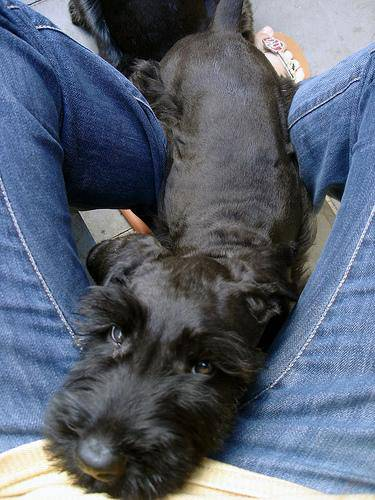

In [209]:
Image(test_filenames[1])

In [211]:
len(test_filenames)

10357

In [212]:
# Create test data batch
test_data=create_data_batches(test_filenames, test_data=True)

Creating test data batches....


In [213]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**NOTES** Calling `predict()` on our full model nd passing it the test data batch will take a long time to run(about ~ an hour).

this is because its running a large new models, find patterns and still create predictions


it will run 10357/32 ~ 324 batches

In [214]:
# Make predictions on test data batch using the loaded full model
test_predictions=loaded_full_model.predict(test_data,
                                            verbose=1)

324/324 [==============================] - 1165s 4s/step


Save predictions (Numpy array) to csv file (for access later)

# np.savetxt("drive/MyDrive/dog-breed-identification/", test_predictions, delimiter=",")

In [216]:
# Save predictions (NumPy array) to csv file for access later
np.savetxt("drive/MyDrive/dog-breed-identification/preds_array.csv", test_predictions, delimiter=",")

In [217]:
# Load predictions (NumPy array) from csv file
test_predictions=np.loadtxt("drive/MyDrive/dog-breed-identification/preds_array.csv", delimiter=",")

In [218]:
test_predictions[:10]

array([[1.26607773e-07, 2.74226730e-09, 9.98796934e-10, ...,
        8.40883266e-11, 2.63439233e-07, 2.49234375e-08],
       [4.07817851e-08, 7.90315823e-07, 1.40692393e-07, ...,
        6.42902194e-07, 1.02406215e-10, 4.33433129e-08],
       [1.74797999e-04, 6.17461149e-09, 2.26341212e-09, ...,
        5.29346948e-08, 3.67502162e-06, 9.73864734e-01],
       ...,
       [6.20252132e-01, 9.28290333e-10, 3.19771409e-09, ...,
        4.43909298e-10, 5.19479251e-08, 5.23835042e-05],
       [8.07969733e-11, 8.29952634e-11, 7.15877141e-12, ...,
        3.63511998e-12, 3.18067892e-13, 3.82472776e-10],
       [1.18335813e-17, 1.05396989e-08, 1.25343041e-13, ...,
        1.05446893e-11, 4.69224811e-14, 5.77207849e-15]])

In [219]:
test_predictions.shape

(10357, 120)

Preparing test dataset predictions for submission

Looking at the submission format, we need an id column and a column for each dog breed.. in a csv

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


To get the data in this format, we will:

* create a pandas dataframe with am id column, as well as a column for each dog breed 

* add data to the id column by extracting the test image ids from their filepaths

* add data (prediction probabilities) to each of the dog breed columns

* export dataframe as a csv for submission


In [220]:
list(unique_breeds)

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [221]:
["id"]+list(unique_breeds)

['id',
 'affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenen

In [225]:
# Create a pandas dataframe with empty columns
preds_df=pd.DataFrame(columns=["id"]+ list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [226]:
test_filenames

['drive/MyDrive/dog-breed-identification/test/e7dc8cc599049ea9fa2a172c88646c57.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7be7b911a4cba9fdfa4105ec4776370.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7e9dd51302fe08c1c89a550e183cf07.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7b357150635c250757363718e4dae86.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7b608110b0e29120d8740f37e85f3d0.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7e9624f2a2e61ab187358f5968bfde8.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7ed96b272013c6de9505a753816ce75.jpg',
 'drive/MyDrive/dog-breed-identification/test/e7f95aabf775a636b3893ffa120adaf9.jpg',
 'drive/MyDrive/dog-breed-identification/test/e83d7fa8fdfba0ec577f9c8df811d439.jpg',
 'drive/MyDrive/dog-breed-identification/test/e806a67a05289ac6de6831001664b81b.jpg',
 'drive/MyDrive/dog-breed-identification/test/e8232c9a79f0e77e9b4c5fca60682d41.jpg',
 'drive/MyDrive/dog-breed-identification/test/e8319b1410a984291d7

In [228]:
test_path

'drive/MyDrive/dog-breed-identification/test/'

In [229]:
os.path.splitext(test_filenames[0])

('drive/MyDrive/dog-breed-identification/test/e7dc8cc599049ea9fa2a172c88646c57',
 '.jpg')

In [233]:
# append test image IDS to preds_df
test_ids=[os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"]=test_ids

In [234]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7dc8cc599049ea9fa2a172c88646c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e7be7b911a4cba9fdfa4105ec4776370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e7e9dd51302fe08c1c89a550e183cf07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e7b357150635c250757363718e4dae86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e7b608110b0e29120d8740f37e85f3d0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
# add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)]=test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7dc8cc599049ea9fa2a172c88646c57,1.26608e-07,2.74227e-09,9.98797e-10,2.73135e-11,3.71815e-08,2.50437e-09,4.59015e-10,5.00389e-09,7.6658e-13,2.10665e-10,1.31268e-11,6.72092e-07,3.76172e-08,3.35975e-09,3.01383e-11,6.25254e-09,0.279047,2.92428e-10,7.22527e-10,1.33144e-07,3.62281e-11,2.84745e-10,7.9556e-11,1.87618e-09,2.03239e-09,5.58892e-10,7.88295e-10,3.39471e-09,6.74138e-11,8.8963e-07,1.34046e-09,4.67622e-09,3.30342e-07,2.52457e-05,4.92501e-09,2.99348e-12,1.25088e-08,1.90635e-11,1.72004e-10,...,6.5738e-10,8.86187e-08,2.12315e-09,1.51987e-09,0.720673,5.86559e-05,2.22468e-09,1.31795e-08,3.595e-09,1.56051e-10,9.97807e-13,1.0288e-09,2.4691e-09,9.30357e-09,6.22153e-08,9.47187e-06,9.29679e-10,6.0387e-11,5.5253e-11,1.41178e-06,2.86047e-06,6.5212e-07,1.76562e-07,7.07537e-12,2.24506e-07,1.29415e-07,2.74303e-10,7.74712e-10,7.20085e-10,7.3136e-07,1.96387e-08,2.69619e-09,6.04802e-10,5.16722e-09,2.89499e-10,1.88821e-10,1.61165e-07,8.40883e-11,2.63439e-07,2.49234e-08
1,e7be7b911a4cba9fdfa4105ec4776370,4.07818e-08,7.90316e-07,1.40692e-07,1.49199e-08,2.29204e-10,3.68783e-09,3.1826e-11,1.24678e-09,7.63002e-11,7.26611e-14,1.45157e-09,5.89167e-09,3.59291e-09,2.93955e-07,5.0931e-10,7.37149e-11,8.17309e-11,1.39651e-09,3.17018e-09,3.98629e-12,3.47309e-05,3.89523e-12,1.74239e-09,0.00811476,1.5884e-12,5.70377e-11,5.58005e-07,1.30881e-06,3.07011e-08,5.73773e-10,1.34063e-10,6.7659e-12,5.27967e-08,3.41455e-10,1.05517e-10,2.5691e-09,1.20172e-10,3.12259e-09,3.30433e-10,...,9.3826e-07,1.85462e-09,2.23996e-11,2.36213e-10,2.22276e-09,2.34485e-09,3.03857e-12,3.07103e-10,2.50146e-08,8.73313e-10,1.98825e-09,1.02535e-08,6.95983e-11,5.77431e-10,1.31368e-11,5.35543e-07,0.953088,5.68552e-08,2.40868e-11,1.25585e-12,1.97365e-10,6.43852e-10,9.14274e-09,1.15278e-06,4.21012e-07,1.01987e-11,0.00133041,2.62517e-08,4.09475e-09,5.78102e-07,1.38525e-10,3.46316e-12,4.3048e-12,4.50124e-10,1.24321e-11,1.11968e-11,7.70845e-10,6.42902e-07,1.02406e-10,4.33433e-08
2,e7e9dd51302fe08c1c89a550e183cf07,0.000174798,6.17461e-09,2.26341e-09,1.04396e-07,6.19233e-08,1.94688e-09,0.0240407,5.48948e-09,9.27925e-10,3.37764e-09,1.07772e-10,5.85037e-07,1.62019e-09,8.20297e-09,3.47383e-11,1.5157e-08,6.2495e-08,2.45825e-08,1.37858e-09,1.70671e-08,2.57399e-09,4.845e-08,5.93604e-07,2.87512e-09,3.88719e-11,3.29119e-10,2.07945e-05,1.17876e-09,4.17447e-11,5.1736e-06,1.09367e-10,1.00828e-09,3.98638e-10,5.06291e-09,1.26326e-11,5.05399e-11,4.87105e-10,4.82538e-09,3.30701e-07,...,2.98779e-09,6.49867e-09,4.17268e-13,1.90283e-09,2.52757e-05,1.93133e-06,2.12914e-09,0.000107243,2.86833e-09,1.80749e-10,1.96895e-11,4.11809e-10,5.14079e-12,5.06943e-09,4.67046e-09,1.96393e-07,5.70127e-10,2.37107e-07,4.04376e-09,1.06062e-09,4.44721e-06,5.3166e-12,0.000523703,1.20617e-09,6.42297e-09,5.45186e-12,1.80325e-07,6.46522e-08,1.28627e-11,7.70841e-07,2.21695e-08,0.001127,5.9438e-10,5.49554e-11,4.03501e-10,2.86627e-09,3.61947e-06,5.29347e

In [236]:
# save our predictions dataframe to csv for submission
preds_df.to_csv("drive/MyDrive/dog-breed-identification/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

Making predictions on custom images

To make predictions on custom images, we will:

* Get the filepaths of our own images

* Turn the filepaths into data batches using `create_data_batches`. and since our custom images wont have labels, we set the `test_data` parameter to `True`

* Pass the custom image data batch to our models `predict()` method

* Convert the prediction output probabilities to prediction labels

* Compare the predicted labels to the custom labels

In [237]:
# get custom image filepaths
custom_path="drive/MyDrive/dog-breed-identification/custom_dogs/"
custom_image_paths=[custom_path + fname for fname in os.listdir(custom_path)]

In [238]:
custom_image_paths

['drive/MyDrive/dog-breed-identification/custom_dogs/custom_dog2.jpg',
 'drive/MyDrive/dog-breed-identification/custom_dogs/custom_dog4.jpg',
 'drive/MyDrive/dog-breed-identification/custom_dogs/custom_dog5.jpg',
 'drive/MyDrive/dog-breed-identification/custom_dogs/cutom_dog1.jpg',
 'drive/MyDrive/dog-breed-identification/custom_dogs/custom_dog3.jpg']

In [239]:
# Turn custom images into batch datasets
custom_data=create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches....


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [240]:
# make predictions on the custom data
custom_preds=loaded_full_model.predict(custom_data)

In [241]:
custom_preds

array([[2.28333068e-08, 4.84791894e-12, 2.17871822e-13, 9.78197644e-12,
        4.10323224e-08, 2.00753053e-10, 8.90687191e-10, 2.40712041e-07,
        9.63399586e-12, 2.32220037e-12, 1.24652719e-11, 6.70200617e-10,
        6.90549562e-11, 7.47004592e-09, 2.32944133e-11, 4.23825645e-12,
        8.48333140e-11, 7.27131354e-13, 1.03570234e-11, 1.37818454e-13,
        2.19832277e-11, 7.65934927e-10, 5.70008263e-10, 1.02994020e-11,
        1.79196574e-10, 3.11666604e-08, 3.68658121e-13, 1.26402413e-11,
        1.23939303e-08, 2.74385775e-11, 9.99606788e-01, 2.46472753e-09,
        2.22651633e-10, 4.55110311e-10, 1.44931777e-12, 1.39699585e-10,
        1.11057330e-09, 1.25185129e-09, 9.03374944e-11, 4.89730145e-10,
        2.21457780e-13, 2.73374545e-10, 4.72184070e-10, 4.84491750e-07,
        3.90015215e-10, 5.74142867e-09, 1.16603049e-09, 2.15553311e-10,
        1.43581171e-11, 2.44194276e-10, 3.32468941e-10, 3.10192681e-13,
        1.11020892e-09, 8.94229135e-11, 2.95307334e-09, 4.091413

In [242]:
custom_preds.shape

(5, 120)

In [243]:
# Get custom image prediction labels
custom_pred_labels=[get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['chow', 'border_collie', 'eskimo_dog', 'pug', 'afghan_hound']

In [244]:
# Get custom images(our unbatchify() function wont work since there are no labels.......maybe we could fix this later)
custom_images=[]
# loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)
  # unwind data into just images

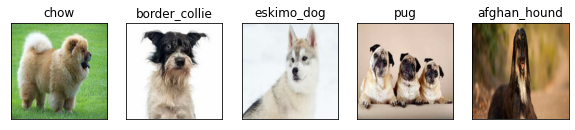

In [248]:
# check custom predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1,5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)